/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_714640/2912495762.py:21: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  center_x, center_y = transform(wgs84, tif_proj, center_lon, center_lat)


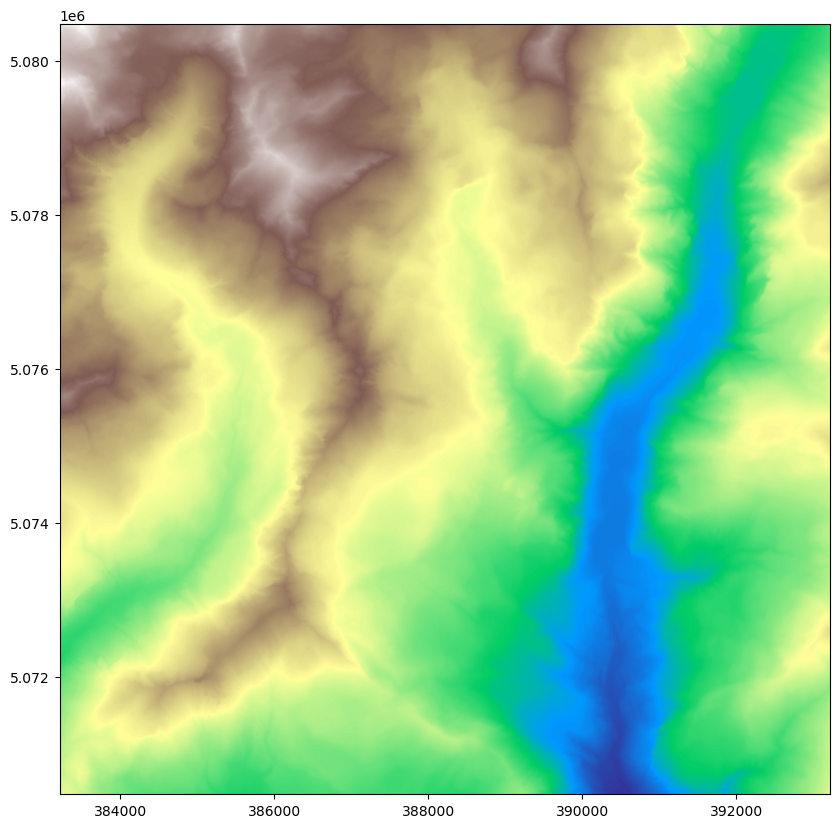

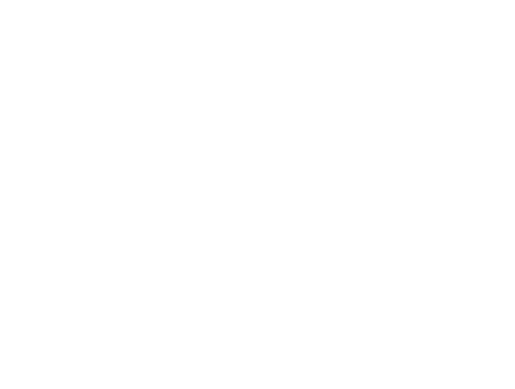

In [1]:
from scripts.imports import *

# Define the center point in latitude and longitude
center_lat = 45.8238
center_lon = 7.5609

# Define the radius of the square box (10km / 2 = 5km)
radius = 5000  # in meters

# Open the .tif file with rasterio
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    # Get the coordinate system of the .tif file
    tif_crs = src.crs

    # Define the projection for the latitude and longitude (WGS84)
    wgs84 = Proj(init='epsg:4326')

    # Transform the center point to the coordinate system of the .tif file
    tif_proj = Proj(tif_crs)
    center_x, center_y = transform(wgs84, tif_proj, center_lon, center_lat)

    # Define the bounding box in the .tif file's coordinate system
    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius
    bounding_box = [min_x, min_y, max_x, max_y]

    # Crop the .tif file to the bounding box
    window = rasterio.windows.from_bounds(*bounding_box, transform=src.transform)
    cropped_image = src.read(window=window)

    # Update the transform for the cropped image
    cropped_transform = src.window_transform(window)

    # Display the cropped image
    plt.figure(figsize=(10, 10))
    show(cropped_image, transform=cropped_transform, cmap='terrain')
    plt.axis('off')
    plt.show()

/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_715124/1130501720.py:16: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  center_x, center_y = transform(wgs84, tif_proj, center_lon, center_lat)


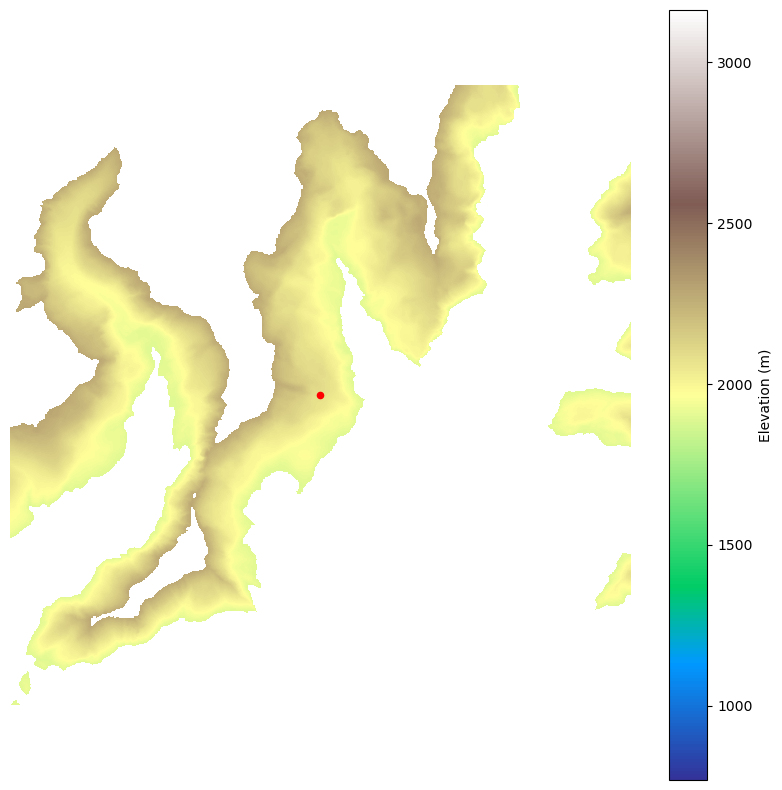

The area of the region within 200m of 2091m elevation is 32083200.00 square meters.


In [4]:
from scripts.imports import *
from rasterio.plot import show
from rasterio.windows import from_bounds

# Open the raster data
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    # Define the center point and box dimensions
    center_lat = 45.8238
    center_lon = 7.5609
    radius = 5000  # 10km / 2 = 5km each side

    # Transform the center point to the coordinate system of the .tif file
    wgs84 = Proj(init='epsg:4326')
    tif_proj = Proj(src.crs)
    center_x, center_y = transform(wgs84, tif_proj, center_lon, center_lat)

    # Define the bounding box in the coordinate system of the .tif file
    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius

    # Crop the .tif file to the bounding box
    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    cropped_image = src.read(1, window=window)
    cropped_transform = src.window_transform(window)

    # Squeeze the extra dimension if it exists
    cropped_image = np.squeeze(cropped_image)

    # Mask the regions where the elevation is within 200 meters of 2091 meters
    target_elevation = 2091
    elevation_tolerance = 200
    mask = (cropped_image >= (target_elevation - elevation_tolerance)) & (cropped_image <= (target_elevation + elevation_tolerance))
    masked_dtm = np.where(mask, cropped_image, np.nan)  # Set non-masked areas to NaN

    # Compute the area of the masked region
    pixel_area = np.product(src.res)  # Calculate the area of one pixel in square meters
    masked_area = np.sum(mask) * pixel_area

    # Convert geographic coordinates to image coordinates within the cropped image
    col, row = ~cropped_transform * (center_x, center_y)

    # Get the full range of elevation data from the cropped DTM
    vmin, vmax = np.nanmin(cropped_image), np.nanmax(cropped_image)

    # Display the masked DTM region with terrain colormap using the full DTM color range
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_dtm, cmap='terrain', vmin=vmin, vmax=vmax)  # Apply the full DTM range
    plt.colorbar(label='Elevation (m)')
    plt.scatter(col, row, color='red', s=20)  # Plot the point
    plt.axis('off')
    plt.show()

    # Print the area of the masked region
    print(f'The area of the region within 200m of {target_elevation}m elevation is {masked_area:.2f} square meters.')